In [1]:
# import things
%matplotlib inline

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import helper
import NeuralNet

In [2]:
# Define transform function
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,0.5,0.5,0.5), std=(0.5,0.5,0.5,0.5))])
# Downlaod and load the training set
trainset = datasets.FashionMNIST('F_MNIST_data', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
# Download and load the test set
testset = datasets.FashionMNIST('F_MNIST_data', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

## Image overview

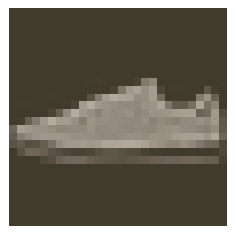

In [3]:
images, labels = next(iter(trainloader))
helper.imshow(images[0,])

## Let's train a network

In [4]:
model = NeuralNet.Network(784, 10, [512, 256, 128])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
NeuralNet.train(model, trainloader, testloader, criterion, optimizer, epochs=2)

Epoch: 1/2.. Training Loss: 1.581 Test Loss: 0.880 Accuracy: 0.669
Epoch: 1/2.. Training Loss: 0.961 Test Loss: 0.696 Accuracy: 0.745
Epoch: 1/2.. Training Loss: 0.818 Test Loss: 0.644 Accuracy: 0.753
Epoch: 1/2.. Training Loss: 0.782 Test Loss: 0.617 Accuracy: 0.762
Epoch: 1/2.. Training Loss: 0.703 Test Loss: 0.584 Accuracy: 0.780
Epoch: 1/2.. Training Loss: 0.716 Test Loss: 0.565 Accuracy: 0.784
Epoch: 1/2.. Training Loss: 0.660 Test Loss: 0.561 Accuracy: 0.790
Epoch: 1/2.. Training Loss: 0.618 Test Loss: 0.548 Accuracy: 0.791
Epoch: 1/2.. Training Loss: 0.650 Test Loss: 0.540 Accuracy: 0.804
Epoch: 1/2.. Training Loss: 0.609 Test Loss: 0.519 Accuracy: 0.808
Epoch: 1/2.. Training Loss: 0.580 Test Loss: 0.525 Accuracy: 0.803
Epoch: 1/2.. Training Loss: 0.618 Test Loss: 0.528 Accuracy: 0.810
Epoch: 1/2.. Training Loss: 0.594 Test Loss: 0.500 Accuracy: 0.820
Epoch: 1/2.. Training Loss: 0.600 Test Loss: 0.534 Accuracy: 0.802
Epoch: 1/2.. Training Loss: 0.613 Test Loss: 0.486 Accuracy: 0

## Saving and Loading Model

In [6]:
print('The model: \n\n ', model, '\n')
print('The state dict keys: \n\n ', model.state_dict().keys())

The model: 

  Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
) 

The state dict keys: 

  odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


the simplest thing to save the state dict is using `torch.save`, e.g. we can save it to a file `checkpoint.pth`

In [7]:
torch.save(model.state_dict(), 'checkpoint.pth')

Then, we can also load the state dict with `torch.load`

In [8]:
state_dict = torch.load('./checkpoint.pth')
print(state_dict.keys())

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


And to load it to the model, we can use `model.load_state_dict(state_dict)`

In [9]:
model.load_state_dict(state_dict)

#### But, what if the model we created doesn't have exactly the same architecture? Then, it will fail to load

In [10]:
model = NeuralNet.Network(784, 10, [400, 200, 100])
# this will throw an error because the tensor sizes are wrong
model.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for Network:
	size mismatch for hidden_layers.0.weight: copying a param of torch.Size([400, 784]) from checkpoint, where the shape is torch.Size([512, 784]) in current model.
	size mismatch for hidden_layers.0.bias: copying a param of torch.Size([400]) from checkpoint, where the shape is torch.Size([512]) in current model.
	size mismatch for hidden_layers.1.weight: copying a param of torch.Size([200, 400]) from checkpoint, where the shape is torch.Size([256, 512]) in current model.
	size mismatch for hidden_layers.1.bias: copying a param of torch.Size([200]) from checkpoint, where the shape is torch.Size([256]) in current model.
	size mismatch for hidden_layers.2.weight: copying a param of torch.Size([100, 200]) from checkpoint, where the shape is torch.Size([128, 256]) in current model.
	size mismatch for hidden_layers.2.bias: copying a param of torch.Size([100]) from checkpoint, where the shape is torch.Size([128]) in current model.
	size mismatch for output.weight: copying a param of torch.Size([10, 100]) from checkpoint, where the shape is torch.Size([10, 128]) in current model.

> This means that, we need to rebuild the model exactly as it was when trained. Hence, __information about the model architectures need to be saved in the `checkpoint`, along with `state_dict`__.

We can do this by defining a dictionary that takes all information we need above

In [11]:
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}
torch.save(checkpoint, 'checkpoint.pth')

Now that we have save all the information in `checkpoint.pth`, we can even build a function to load checkpoints

In [12]:
def load_checkpoint(checkpoint_path):
    'load a checkpoint of model'
    checkpoint = torch.load(checkpoint_path)
    model = NeuralNet.Network(checkpoint['input_size'],
                              checkpoint['output_size'],
                              checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [13]:
model = load_checkpoint('./checkpoint.pth')
print(model)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=100, bias=True)
  )
  (output): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
)
